In [1]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import sys
from scipy import stats
%matplotlib inline

#Problem specific libarires:
import scipy.signal as sig
import Pendulum_Module as pm

sys.path.append('/Users/Daniel Fogh/Desktop/MAIN_(BU_25-07-22)/BSc_Samlet/3. Year/AppStat/AppStat_Code')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

Importing and partitioning data

In [2]:
#Importing period data-files:
names = ['chamilla', 'daniel', 'emil', 'julius', 'sejr']

#Creating dictionary of all data (MIGHT NOT BE THE BEST WAY TO IMPORT THE DATA)
N_dict={}
t_dict={}

for i, name in enumerate(names):
    data = np.genfromtxt(str(name)+'.dat', delimiter='', skip_header=0, skip_footer=0, dtype=float)
    N, t = data[:, 0], data[:, 1]
    N, t = N[N<26], t[N<26] #Including only the 25 first measurements                                   
    N_dict["{0}".format(i+1)] = N
    t_dict["{0}".format(i+1)] = t

In [3]:
#Length data
#Combined mesurements before and after the experiment, to account for string-stretching
l_data = np.array([182.1, 183.6, 182.2, 186.6, 183.6, 183.9, 182.1, 182.9, 182.4, 182.6])*1E-2  #SI conversion factor, measured in cm
h_data = np.array([60.7, 61.0, 61.6, 61.4, 61.5])*(1E-3/2)  #measured in mm, divided by 2 as we measured diameter
ls_data = np.array([0.5, 0.5, 0.5, 0.5, 0.8, 1.0, 0.3, 0.5, 0.5, 0.5])*1E-3  #measured in mm
hs_data = np.array([0.05, 0.05, 0.05, 0.05, 0.05])*(1E-3/2)   #measured in mm, divided by 2 as we measured diameter

#NOTE: I've not included Length measurements done with the old hierloom ruler.

Combining measurements to get $L\pm \sigma_L$ for entire group. Since $l$ and $h$ measurement-arrays don't have same size, we take the weighted mean of all measurements first and then calculate $L$. If $\chi^2$ is very big, $p$ will be very small, and this indicates our uncertainties are waaay underestimated. for $l$, only multiplying our errors by a factor 40 brought the values up to a acceptable level.

In [4]:
#Performing weighted means:
l, l_err, *l_chi = pm.wmean(l_data, ls_data)
h, h_err, *h_chi = pm.wmean(h_data, hs_data)

L = l+h
L_err = np.sqrt(l_err**2 + h_err**2) #By error-propagation

print('l weighted', l, l_err, l_chi)
print('h weighted', h, h_err, h_chi)
print('L =', L, L_err)

l weighted 1.8293851024829197 0.00015490642551732828 [7141.4932511248035, 0.0]
h weighted 0.03062 1.1180339887498949e-05 [228.79999999999933, 2.392858838371131e-48]
L = 1.8600051024829198 0.00015530937082660392


    Comment: Error on L seems way to low.

Finding the period through fitting; this procedure is to be repeated seperately for each of the 5 measurement-series. Afterwards, the 5 estimates gets combined through a weighted mean to a single measurement $T\pm\sigma_T$ to be used to find $g$.

    Comment: (N,t) data-files do not start at the same time!

In [5]:
#We can make this into a loop later, first we just play around with the first dataset:
N, t = N_dict['1'], t_dict['1']

In [6]:
#Defining fitting function.
def T_func(N,T,t0):
    return T*N+t0

#Define chi2 
def chi2_T(N,t,ts,T,t0) : #Note: must not be a function of x
    y_fit = T_func(N,T,t0)
    chi2 = np.sum(((t - y_fit) / ts)**2)
    return chi2

#First time around, we just assign some random error to each data-point
ts=1

#Define a object to minimze
miniobj = lambda T,t0: chi2_T(N,t,ts,T,t0)

#Fitting
miniobj.errordef = Minuit.LEAST_SQUARES
minuit_fit1 = Minuit(miniobj, T=7, t0=10)     
minuit_fit1.migrad()                            

#Extracting fit-parameters:
pm.printnice(minuit_fit1, N)

print(minuit_fit1.parameters[0], minuit_fit1.values[0], minuit_fit1.errors[0])

Fit value: T = 2.7350 +/- 0.0277
Fit value: t0 = 94.5125 +/- 0.4123

Prob(Chi2 = 0.1, Ndof = 23) = 1.0000
T 2.7350220000002743 0.02773501037026221


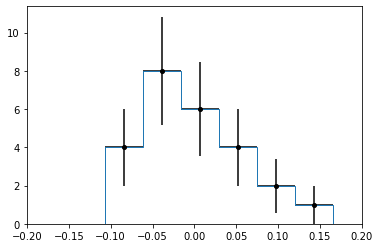

In [39]:
#Calculating residuals:
t_fit = T_func(N, *minuit_fit1.values) #Calculating expected times according to previous fit
res = t-t_fit                          #Calculating residuals

#Extracting data-points with error-bars from binned data, so we can fit a gaussian to residuals
xmin, xmax = min(res), max(res)
counts, bin_edges = np.histogram(res, bins=6,  range=(xmin,xmax), density=False)
res_x = 0.5*(bin_edges[:-1] + bin_edges[1:])[counts>0] 
res_y = counts[counts>0]       
res_sx = (bin_edges[1]-bin_edges[0])*0.5 #The binwidth
res_sy = np.sqrt(res_y) #Poisson error

#Plotting (Just for checking)



plt.figure()
plt.hist(res, bins=6, range=(xmin, xmax), histtype='step')
plt.errorbar(res_x, res_y, yerr=res_sy, xerr=res_sx, fmt='.', color='k', ms=8)
plt.xlim(-0.2,0.2)
plt.show()

In [15]:
#Fitting a gaussian to the residual-histogram
#Define fitting model
def gauss(x, A, mu, sigma):
    z = (x - mu) / sigma
    return A*(np.sqrt(2*np.pi)*sigma)**(-1) * np.exp(-0.5 * z**2)

def chi2_gauss(x, y, sy, A, mu, sigma) :
    y_fit = gauss(x, A, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2


#Define a object to minimze
miniobj2 = lambda A, mu, sigma: chi2_gauss(res_x, res_y, res_sy, A, mu, sigma)

#Fitting
miniobj2.errordef = Minuit.LEAST_SQUARES
minuit_fit2 = Minuit(miniobj2, A=0.5, mu=0.0, sigma=0.02)     #Setup of init. values
minuit_fit2.migrad()       

#Extracting fit-parameters:
pm.printnice(minuit_fit2, res_x)

print('this is the error on each datapoint',minuit_fit2.values[2])

Fit value: A = 1.2644 +/- 0.3133
Fit value: mu = -0.0177 +/- 0.0225
Fit value: sigma = 0.0754 +/- 0.0235

Prob(Chi2 = 0.5, Ndof = 3) = 0.9124
this is the error on each datapoint 0.07540013773892339


(-0.2, 0.2)

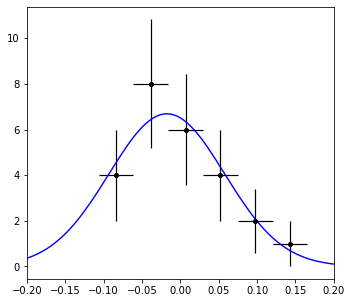

In [24]:
#Plotting our fit just to double-check
xmin, xmax = min(res_x), max(res_x)
res_x_fit = np.linspace(xmin-1, xmax+1, 500)
res_y_fit = gauss(res_x_fit, *minuit_fit2.values)

fig, ax = plt.subplots(figsize=(5.5,5))
plt.errorbar(res_x, res_y , yerr=res_sy, xerr=res_sx, fmt='k.', elinewidth=1.2, ms=8)
plt.plot(res_x_fit, res_y_fit, c='b', lw=1.4)
plt.xlim(-0.2,0.2)

In [26]:
#Performing period-fit again, but with new uncertanties:
ts = minuit_fit2.values[2]
miniobj3 = lambda T,t0: chi2_T(N,t,ts,T,t0)
miniobj3.errordef = Minuit.LEAST_SQUARES
minuit_fit3 = Minuit(miniobj3, T=7, t0=10)     
minuit_fit3.migrad()                            

#Extracting fit-parameters:
pm.printnice(minuit_fit3, N)
print(minuit_fit3.parameters[0], minuit_fit3.values[0], minuit_fit3.errors[0])

Fit value: T = 2.7350 +/- 0.0021
Fit value: t0 = 94.5125 +/- 0.0311

Prob(Chi2 = 17.8, Ndof = 23) = 0.7657
T 2.7350219999987226 0.002091223353001082


### FANCY PLOT (FOR THE PAPER)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


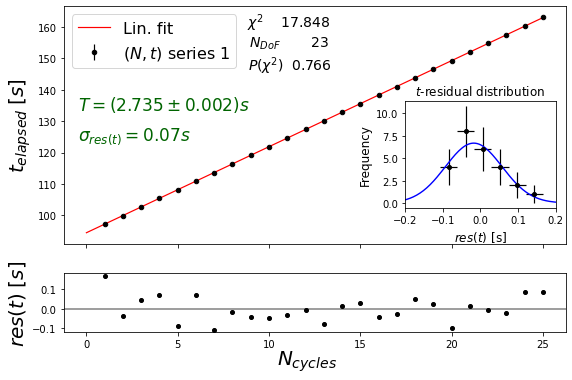

In [109]:
#Producing residuals
x_fit = np.linspace(0, 25, 500)
y_fit = T_func(x_fit, *minuit_fit3.values)
y_res = t-T_func(N, *minuit_fit3.values) #Notice we use x and not x_fit

#Figure
fig,ax=plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]},figsize=(9,6), sharex=True) #Producing two plots in the right size

#Fitplot
ax[0].errorbar(N, t , yerr=ts, fmt='k.', elinewidth=1.2, ms=9, label=r'($N,t$) series 1') #Use Zorder
ax[0].plot(x_fit, y_fit, label='Lin. fit', c='r', lw=1.2)
ax[0].set_ylabel(r'$t_{elapsed} \; [s]$',fontsize=20)
ax[0].legend(fontsize=16,loc="upper left")
fig.text(0.5, 0.06,r'$N_{cycles}$', ha='center', va='center', fontsize=20)

#Residualplot
ax[1].plot(N, y_res,'.', color='k', markersize=8,zorder=10)
ax[1].set_ylabel(r'$res(t) \; [s]$',fontsize=20)
ax[1].axhline(y=0, color='gray', linestyle='-')


#Dictionary for plottingparameters (Has to be done manually to be pretty; values can be added in manually aswell)
Chi2_value = minuit_fit3.fval
Ndof = len(N) - len(minuit_fit3.values[:])
Chi2_prob = stats.chi2.sf(Chi2_value, Ndof)

d = {r'$\chi^2$':       Chi2_value,
     r'$N_{DoF}$':      Ndof,
     r'$P(\chi^2)$':    Chi2_prob}

text = nice_string_output(d, extra_spacing=1, decimals=3) #A library-function from "External-functions"
plt.text(0.45, 0.98, text, fontsize=14, ha='center', va='top', transform=ax[0].transAxes) #First two numbers are relative locations
plt.text(-0.45,1.0,r'$T=(2.735 \pm 0.002) s$',fontsize=17, c='darkgreen')
plt.text(-0.45,0.85,r'$\sigma_{res(t)}=0.07 s$', fontsize=17, c='darkgreen')


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ax1=ax[0].inset_axes(bounds = [0.68, 0.15, 0.3, 0.45])
ax1.errorbar(res_x, res_y , yerr=res_sy,xerr=res_sx, fmt='k.', elinewidth=1.2, ms=8)
ax1.plot(res_x_fit, res_y_fit, c='b', lw=1.4)
ax1.set_xlabel(r'$res(t)$ [s]', fontsize=12)
ax1.set_ylabel('Frequency',fontsize=12)
ax1.set_title(r'$t$-residual distribution')
ax1.set_xlim(-0.2,0.2)

plt.savefig('PeriodMoneyPlot.eps')
plt.show()